# AIDI 1100 - Final Project

Group details - 
<br>Jasmeet Kaur 100881373
<br>Sangeetha Nair 100884883
<br>Shubham Jindal 100843466
<br>Viviana Lopez 100873273

# Web Scraper IMDB Movies

In this project we build a step by step web scraper using Python.

We are scraping only the data we need.

For this project, we scraped data from IMDb’s “Top 1000” movies. The information gathered from each movie are:
- Rank
- Movie Name
- Rating
- Movie URL
- Movie Year
- Genre
- Director Name
- IMDB Rating
- Metascore
- Actors

Link - https://www.imdb.com/search/title/?groups=top_1000&sort=user_rating

<img src="files/IMDB.png">

## Importing Libraries

In [1]:
import requests
from requests import get
from bs4 import BeautifulSoup
from lxml import etree as et
import time
import random
import json
from unidecode import unidecode
import pandas as pd
import numpy as np
import sqlite3
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

#### Introduction to BeautifulSoup
BeautifulSoup is a class in the BS4 library of python made for the purpose of parsing HTML or XML document.

Think of any website on the internet and you want to collect only a specific detail of the subject and there are n number of categories , how long will you scroll. BeautifulSoup allows you to fetch that specific detail from the webpage for every category in a more structured manner.

## Scraping from Web Page

Setting up the header for the web request

In [2]:
header = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.138 Safari/537.36", 'Accept-Language': 'en-US, en;q=0.5'}

There are 1000 movies and each page has 50 movies listed.

So the first 50 movies' url: https://www.imdb.com/search/title/?groups=top_1000&sort=user_rating,desc&start=1&ref_=adv_nxt

Movies from 51 to 100: https://www.imdb.com/search/title/?groups=top_1000&sort=user_rating,desc&start=51&ref_=adv_nxt

Movies from 101 to 150: https://www.imdb.com/search/title/?groups=top_1000&sort=user_rating,desc&start=101&ref_=adv_nxt

...


Let's generate all the page urls and extract the movie urls

In [3]:
movie_urls = []
pages = np.arange(1, 1001, 50)
for page in pages:
    url = 'https://www.imdb.com/search/title/?groups=top_1000&sort=user_rating,desc&start='+str(page)+'&ref_=adv_nxt'
    time.sleep(random.randint(2, 5))
    response = get(url, headers=header)
    soup = BeautifulSoup(response.content, 'html.parser')
    dom = et.HTML(str(soup))
    movie_urls_list = dom.xpath('//h3[@class="lister-item-header"]/a/@href')
    for movie_url in movie_urls_list:
        long_url = "https://www.imdb.com" + movie_url
        short_url = long_url.split("?")[0]
        movie_urls.append(short_url)
print('Total movie urls : ',len(movie_urls))
print('Example - ',movie_urls[0])

Total movie urls :  1000
Example -  https://www.imdb.com/title/tt0111161/


We used the requests library to get the urls and beautifulsoup to get a beautifulsoup object. Then we created a way to query the html for the link. For that we have used the etree module from lxml. 

Upon inspection using chrome developer tools - we found the data was available at an xpath given in the expression above. The expression generates a list of urls.

We then manipulated the urls to be in the proper format and have saved them in a list.

As can be observed from the output we have extracted top 1000 movie urls. We can use these urls to extract all the desired information. 

Creating an empty dataframe to store the values

In [4]:
movies_df = pd.DataFrame()

We will be storing our data into multiple formats:
1. JSON file
2. Excel file
3. Database

We will be using the json format to store the data. Before parsing the data - we need to prepare writing the data into the json.

In [5]:
with open("data_imdb.json", "w") as f:
    json.dump([], f)


def write_to_json(new_data, filename='data_imdb.json'):
    with open(filename, 'r+') as file:
        file_data = json.load(file)
        file_data.append(new_data)
        file.seek(0)
        json.dump(file_data, file, indent=4)

Lets now use use the movie urls to get each movie page and extract the data. We'll store the data into Json file directly using the above function and into the dataframe.

In [6]:
i = 1
pbar = tqdm(desc="Progress", total = 1000)
for movie_url in movie_urls:
    response = get(movie_url, headers=header)
    soup = BeautifulSoup(response.content, 'html.parser')
    dom = et.HTML(str(soup))

    rank = movie_urls.index(movie_url) + 1
    movie_name = dom.xpath('//h1[@data-testid="hero-title-block__title"]/text()')[0]
    if (len(dom.xpath('//a[@class="ipc-link ipc-link--baseAlt ipc-link--inherit-color sc-8c396aa2-1 WIUyh"]/text()')) == 1):
        rating = "Not Rated"
    else:
        rating = dom.xpath('//a[@class="ipc-link ipc-link--baseAlt ipc-link--inherit-color sc-8c396aa2-1 WIUyh"]/text()')[1]
    movie_year = dom.xpath('//a[@class="ipc-link ipc-link--baseAlt ipc-link--inherit-color sc-8c396aa2-1 WIUyh"]/text()')[0]
    genre = dom.xpath('//span[@class="ipc-chip__text"]/text()')
    director_name = dom.xpath('//a[@class="ipc-metadata-list-item__list-content-item ipc-metadata-list-item__list-content-item--link"]/text()')[0]
    imdb_rating = dom.xpath('//span[@class="sc-7ab21ed2-1 jGRxWM"]/text()')[0]
    metascore = dom.xpath('//span[@class="score-meta"]/text()')
    actors_list = dom.xpath('//a[@data-testid="title-cast-item__actor"]/text()')
    actors_list = [unidecode(i) for i in actors_list]
        
    if (len(metascore) == 1):
        meta_score = metascore[0]
    else:
        meta_score = 0
        
    movie_dict = {'Rank': rank,
                  'Movie Name': movie_name,
                  'Rating': rating,
                  'Movie Url': movie_url,
                  'Movie Year': movie_year,
                  'Genre': genre,
                  'Director Name': unidecode(director_name),
                  'IMDB Rating': imdb_rating,
                  'Metascore':meta_score,
                  'Actors': actors_list}
    movies_df = movies_df.append(movie_dict, ignore_index=True)
    write_to_json(movie_dict)

    time.sleep(random.randint(2, 5))
    
    print(i,"/1000", end='\r')
    i=i+1
    pbar.update(1)
print("Completed data Extraction")
pbar.close()

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Completed data Extraction


In [7]:
movies_df

,Rank,Movie Name,Rating,Movie Url,Movie Year,Genre,Director Name,IMDB Rating,Metascore,Actors
0,1,The Shawshank Redemption,R,https://www.imdb.com/title/tt0111161/,1994,[Drama],Frank Darabont,9.3,81,"[Tim Robbins, Morgan Freeman, Bob Gunton, Will..."
1,2,The Godfather,R,https://www.imdb.com/title/tt0068646/,1972,"[Crime, Drama]",Francis Ford Coppola,9.2,100,"[Marlon Brando, Al Pacino, James Caan, Diane K..."
2,3,The Dark Knight,PG-13,https://www.imdb.com/title/tt0468569/,2008,"[Action, Crime, Drama]",Christopher Nolan,9.0,84,"[Christian Bale, Heath Ledger, Aaron Eckhart, ..."
3,4,The Lord of the Rings: The Return of the King,PG-13,https://www.imdb.com/title/tt0167260/,2003,"[Action, Adventure, Drama]",Peter Jackson,9.0,94,"[Elijah Wood, Viggo Mortensen, Ian McKellen, O..."
4,5,Schindler's List,R,https://www.imdb.com/title/tt0108052/,1993,"[Biography, Drama, History]",Steven Spielberg,9.0,94,"[Liam Neeson, Ralph Fiennes, Ben Kingsley, Car..."
...,...,...,...,...,...,...,...,...,...,...
995,996,Sabrina,Passed,https://www.imdb.com/title/tt0047437/,1954,"[Comedy, Drama, Romance]",Billy Wilder,7.6,72,"[Humphrey Bogart, Audrey Hepburn, William Hold..."
996,997,From Here to Eternity,Passed,https://www.imdb.com/title/tt0045793/,1953,"[Drama, Romance, War]",Fred Zinnemann,7.6,85,"[Burt Lancaster, Montgomery Clift, Deborah Ker..."
997,998,Snow White and the Seven Dwarfs,Approved,https://www.imdb.com/title/tt0029583/,1937,"[Animation, Adventure, Family]",William Cottrell,7.6,95,"[Adriana Caselotti, Harry Stockwell, Lucille L..."
998,999,The 39 Steps,Approved,https://www.imdb.com/title/tt0026029/,1935,"[Crime, Mystery, Thriller]",Alfred Hitchcock,7.6,93,"[Robert Donat, Madeleine Carroll, Lucie Mannhe..."


We have successfully extracted data for top 1000 IMDB movies from website through web scraping. Now lets clean some values.

## Data Cleaning

First lets clean the null values from the data

In [8]:
movies_df.isnull().sum()

Rank             0
Movie Name       0
Rating           0
Movie Url        0
Movie Year       0
Genre            0
Director Name    0
IMDB Rating      0
Metascore        0
Actors           0
dtype: int64

We can see that there are no null values in the dataframe so no need to remove any records. 

Lets fix the values of Genre column. It is originally a list, lets convert to string. 

In [9]:
movies_df['Genre'] = movies_df['Genre'].astype(str)
movies_df['Genre'] = movies_df['Genre'].str[1:]
movies_df['Genre'] = movies_df['Genre'].str[:-1]
movies_df['Genre'] = movies_df['Genre'].str.replace("'", "")
movies_df

,Rank,Movie Name,Rating,Movie Url,Movie Year,Genre,Director Name,IMDB Rating,Metascore,Actors
0,1,The Shawshank Redemption,R,https://www.imdb.com/title/tt0111161/,1994,Drama,Frank Darabont,9.3,81,"[Tim Robbins, Morgan Freeman, Bob Gunton, Will..."
1,2,The Godfather,R,https://www.imdb.com/title/tt0068646/,1972,"Crime, Drama",Francis Ford Coppola,9.2,100,"[Marlon Brando, Al Pacino, James Caan, Diane K..."
2,3,The Dark Knight,PG-13,https://www.imdb.com/title/tt0468569/,2008,"Action, Crime, Drama",Christopher Nolan,9.0,84,"[Christian Bale, Heath Ledger, Aaron Eckhart, ..."
3,4,The Lord of the Rings: The Return of the King,PG-13,https://www.imdb.com/title/tt0167260/,2003,"Action, Adventure, Drama",Peter Jackson,9.0,94,"[Elijah Wood, Viggo Mortensen, Ian McKellen, O..."
4,5,Schindler's List,R,https://www.imdb.com/title/tt0108052/,1993,"Biography, Drama, History",Steven Spielberg,9.0,94,"[Liam Neeson, Ralph Fiennes, Ben Kingsley, Car..."
...,...,...,...,...,...,...,...,...,...,...
995,996,Sabrina,Passed,https://www.imdb.com/title/tt0047437/,1954,"Comedy, Drama, Romance",Billy Wilder,7.6,72,"[Humphrey Bogart, Audrey Hepburn, William Hold..."
996,997,From Here to Eternity,Passed,https://www.imdb.com/title/tt0045793/,1953,"Drama, Romance, War",Fred Zinnemann,7.6,85,"[Burt Lancaster, Montgomery Clift, Deborah Ker..."
997,998,Snow White and the Seven Dwarfs,Approved,https://www.imdb.com/title/tt0029583/,1937,"Animation, Adventure, Family",William Cottrell,7.6,95,"[Adriana Caselotti, Harry Stockwell, Lucille L..."
998,999,The 39 Steps,Approved,https://www.imdb.com/title/tt0026029/,1935,"Crime, Mystery, Thriller",Alfred Hitchcock,7.6,93,"[Robert Donat, Madeleine Carroll, Lucie Mannhe..."


Similarly, changing the Actors column also

In [10]:
movies_df['Actors'] = movies_df['Actors'].astype(str)
movies_df['Actors'] = movies_df['Actors'].str[1:]
movies_df['Actors'] = movies_df['Actors'].str[:-1]
movies_df['Actors'] = movies_df['Actors'].str.replace("'", "")
movies_df

,Rank,Movie Name,Rating,Movie Url,Movie Year,Genre,Director Name,IMDB Rating,Metascore,Actors
0,1,The Shawshank Redemption,R,https://www.imdb.com/title/tt0111161/,1994,Drama,Frank Darabont,9.3,81,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi..."
1,2,The Godfather,R,https://www.imdb.com/title/tt0068646/,1972,"Crime, Drama",Francis Ford Coppola,9.2,100,"Marlon Brando, Al Pacino, James Caan, Diane Ke..."
2,3,The Dark Knight,PG-13,https://www.imdb.com/title/tt0468569/,2008,"Action, Crime, Drama",Christopher Nolan,9.0,84,"Christian Bale, Heath Ledger, Aaron Eckhart, M..."
3,4,The Lord of the Rings: The Return of the King,PG-13,https://www.imdb.com/title/tt0167260/,2003,"Action, Adventure, Drama",Peter Jackson,9.0,94,"Elijah Wood, Viggo Mortensen, Ian McKellen, Or..."
4,5,Schindler's List,R,https://www.imdb.com/title/tt0108052/,1993,"Biography, Drama, History",Steven Spielberg,9.0,94,"Liam Neeson, Ralph Fiennes, Ben Kingsley, Caro..."
...,...,...,...,...,...,...,...,...,...,...
995,996,Sabrina,Passed,https://www.imdb.com/title/tt0047437/,1954,"Comedy, Drama, Romance",Billy Wilder,7.6,72,"Humphrey Bogart, Audrey Hepburn, William Holde..."
996,997,From Here to Eternity,Passed,https://www.imdb.com/title/tt0045793/,1953,"Drama, Romance, War",Fred Zinnemann,7.6,85,"Burt Lancaster, Montgomery Clift, Deborah Kerr..."
997,998,Snow White and the Seven Dwarfs,Approved,https://www.imdb.com/title/tt0029583/,1937,"Animation, Adventure, Family",William Cottrell,7.6,95,"Adriana Caselotti, Harry Stockwell, Lucille La..."
998,999,The 39 Steps,Approved,https://www.imdb.com/title/tt0026029/,1935,"Crime, Mystery, Thriller",Alfred Hitchcock,7.6,93,"Robert Donat, Madeleine Carroll, Lucie Mannhei..."


Cleaning Metascore column: changing to int type.

In [11]:
movies_df['Metascore'] = movies_df['Metascore'].astype(int)
movies_df

,Rank,Movie Name,Rating,Movie Url,Movie Year,Genre,Director Name,IMDB Rating,Metascore,Actors
0,1,The Shawshank Redemption,R,https://www.imdb.com/title/tt0111161/,1994,Drama,Frank Darabont,9.3,81,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi..."
1,2,The Godfather,R,https://www.imdb.com/title/tt0068646/,1972,"Crime, Drama",Francis Ford Coppola,9.2,100,"Marlon Brando, Al Pacino, James Caan, Diane Ke..."
2,3,The Dark Knight,PG-13,https://www.imdb.com/title/tt0468569/,2008,"Action, Crime, Drama",Christopher Nolan,9.0,84,"Christian Bale, Heath Ledger, Aaron Eckhart, M..."
3,4,The Lord of the Rings: The Return of the King,PG-13,https://www.imdb.com/title/tt0167260/,2003,"Action, Adventure, Drama",Peter Jackson,9.0,94,"Elijah Wood, Viggo Mortensen, Ian McKellen, Or..."
4,5,Schindler's List,R,https://www.imdb.com/title/tt0108052/,1993,"Biography, Drama, History",Steven Spielberg,9.0,94,"Liam Neeson, Ralph Fiennes, Ben Kingsley, Caro..."
...,...,...,...,...,...,...,...,...,...,...
995,996,Sabrina,Passed,https://www.imdb.com/title/tt0047437/,1954,"Comedy, Drama, Romance",Billy Wilder,7.6,72,"Humphrey Bogart, Audrey Hepburn, William Holde..."
996,997,From Here to Eternity,Passed,https://www.imdb.com/title/tt0045793/,1953,"Drama, Romance, War",Fred Zinnemann,7.6,85,"Burt Lancaster, Montgomery Clift, Deborah Kerr..."
997,998,Snow White and the Seven Dwarfs,Approved,https://www.imdb.com/title/tt0029583/,1937,"Animation, Adventure, Family",William Cottrell,7.6,95,"Adriana Caselotti, Harry Stockwell, Lucille La..."
998,999,The 39 Steps,Approved,https://www.imdb.com/title/tt0026029/,1935,"Crime, Mystery, Thriller",Alfred Hitchcock,7.6,93,"Robert Donat, Madeleine Carroll, Lucie Mannhei..."


Changing datatype of IMDB Rating column to numeric.

In [12]:
movies_df['IMDB Rating'] = pd.to_numeric(movies_df['IMDB Rating'], errors='coerce')
movies_df

,Rank,Movie Name,Rating,Movie Url,Movie Year,Genre,Director Name,IMDB Rating,Metascore,Actors
0,1,The Shawshank Redemption,R,https://www.imdb.com/title/tt0111161/,1994,Drama,Frank Darabont,9.3,81,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi..."
1,2,The Godfather,R,https://www.imdb.com/title/tt0068646/,1972,"Crime, Drama",Francis Ford Coppola,9.2,100,"Marlon Brando, Al Pacino, James Caan, Diane Ke..."
2,3,The Dark Knight,PG-13,https://www.imdb.com/title/tt0468569/,2008,"Action, Crime, Drama",Christopher Nolan,9.0,84,"Christian Bale, Heath Ledger, Aaron Eckhart, M..."
3,4,The Lord of the Rings: The Return of the King,PG-13,https://www.imdb.com/title/tt0167260/,2003,"Action, Adventure, Drama",Peter Jackson,9.0,94,"Elijah Wood, Viggo Mortensen, Ian McKellen, Or..."
4,5,Schindler's List,R,https://www.imdb.com/title/tt0108052/,1993,"Biography, Drama, History",Steven Spielberg,9.0,94,"Liam Neeson, Ralph Fiennes, Ben Kingsley, Caro..."
...,...,...,...,...,...,...,...,...,...,...
995,996,Sabrina,Passed,https://www.imdb.com/title/tt0047437/,1954,"Comedy, Drama, Romance",Billy Wilder,7.6,72,"Humphrey Bogart, Audrey Hepburn, William Holde..."
996,997,From Here to Eternity,Passed,https://www.imdb.com/title/tt0045793/,1953,"Drama, Romance, War",Fred Zinnemann,7.6,85,"Burt Lancaster, Montgomery Clift, Deborah Kerr..."
997,998,Snow White and the Seven Dwarfs,Approved,https://www.imdb.com/title/tt0029583/,1937,"Animation, Adventure, Family",William Cottrell,7.6,95,"Adriana Caselotti, Harry Stockwell, Lucille La..."
998,999,The 39 Steps,Approved,https://www.imdb.com/title/tt0026029/,1935,"Crime, Mystery, Thriller",Alfred Hitchcock,7.6,93,"Robert Donat, Madeleine Carroll, Lucie Mannhei..."


In [13]:
movies_df.dtypes

Rank               int64
Movie Name        object
Rating            object
Movie Url         object
Movie Year        object
Genre             object
Director Name     object
IMDB Rating      float64
Metascore          int64
Actors            object
dtype: object

Now that the data has been cleaned lets export the data to an excel sheet.

In [14]:
movies_df.to_excel('data_imdb.xlsx', index=False)

We have succesfully exported the data to an excel file. Now lets export the data to sqlite database.

In [16]:
con = sqlite3.connect("data_imdb.db")
movies_df.to_sql(name='IMDB_Movies', con=con)
cur = con.cursor()
movies = cur.execute("SELECT * FROM IMDB_Movies LIMIT 5")
rows = movies.fetchall()
con.close()
for row in rows:
    print(row)

(0, 1, 'The Shawshank Redemption', 'R', 'https://www.imdb.com/title/tt0111161/', '1994', 'Drama', 'Frank Darabont', 9.3, 81, 'Tim Robbins, Morgan Freeman, Bob Gunton, William Sadler, Clancy Brown, Gil Bellows, Mark Rolston, James Whitmore, Jeffrey DeMunn, Larry Brandenburg, Neil Giuntoli, Brian Libby, David Proval, Joseph Ragno, Jude Ciccolella, Paul McCrane, Renee Blaine, Scott Mann')
(1, 2, 'The Godfather', 'R', 'https://www.imdb.com/title/tt0068646/', '1972', 'Crime, Drama', 'Francis Ford Coppola', 9.2, 100, 'Marlon Brando, Al Pacino, James Caan, Diane Keaton, Richard S. Castellano, Robert Duvall, Sterling Hayden, John Marley, Richard Conte, Al Lettieri, Abe Vigoda, Talia Shire, Gianni Russo, John Cazale, Rudy Bond, Al Martino, Morgana King, Lenny Montana')
(2, 3, 'The Dark Knight', 'PG-13', 'https://www.imdb.com/title/tt0468569/', '2008', 'Action, Crime, Drama', 'Christopher Nolan', 9.0, 84, 'Christian Bale, Heath Ledger, Aaron Eckhart, Michael Caine, Maggie Gyllenhaal, Gary Oldman

We have successfully exported our data to 3 different modes: JSON file, Excel file and Sqlite3 Database.

## EDA - Exploratory Data Analysis

Importing libraries

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

Plotting chart for number of movies per ratings.

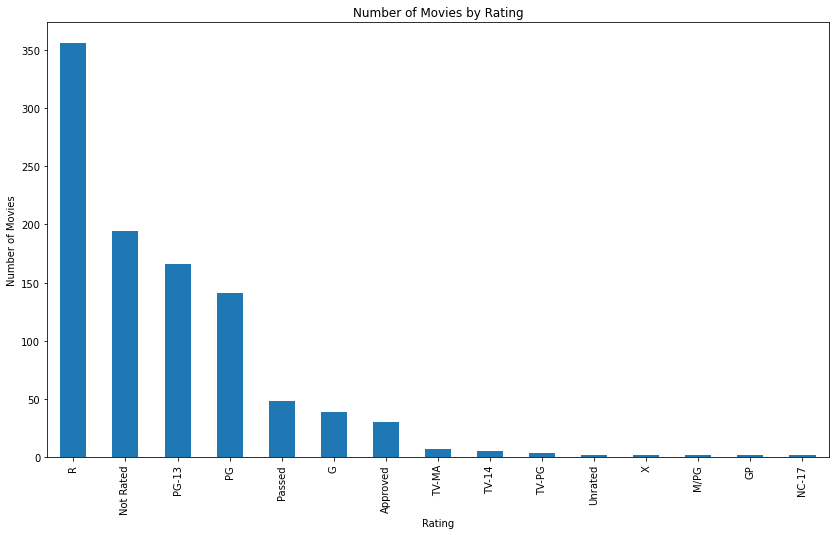

In [18]:
ax = movies_df['Rating'].value_counts().plot(kind='bar',
                                   figsize=(14,8),
                                   title="Number of Movies by Rating")
ax.set_xlabel("Rating")
ax.set_ylabel("Number of Movies")
ax.plot();

Plotting chart for number of movies per year. 

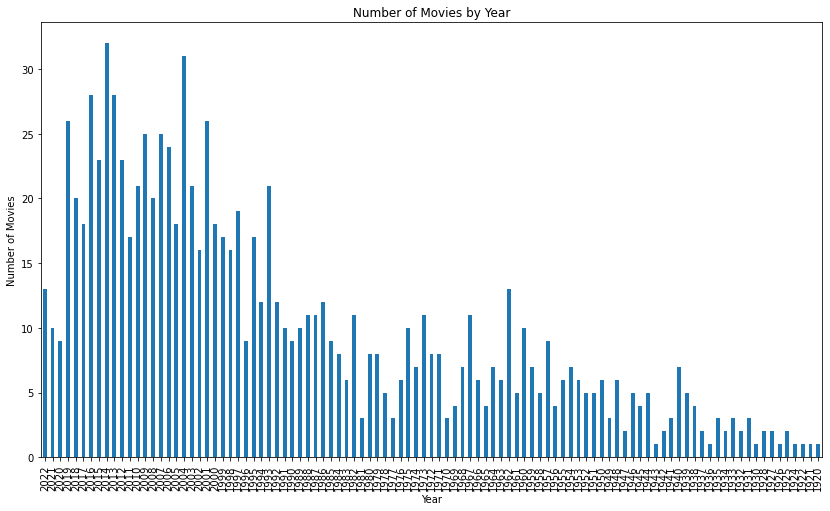

In [19]:
ax = movies_df['Movie Year'].value_counts().sort_index(ascending=False).plot(kind='bar',
                                   figsize=(14,8),
                                   title="Number of Movies by Year")
ax.set_xlabel("Year")
ax.set_ylabel("Number of Movies")
ax.plot();

PLotting chart for number of movies by IMDB Rating.

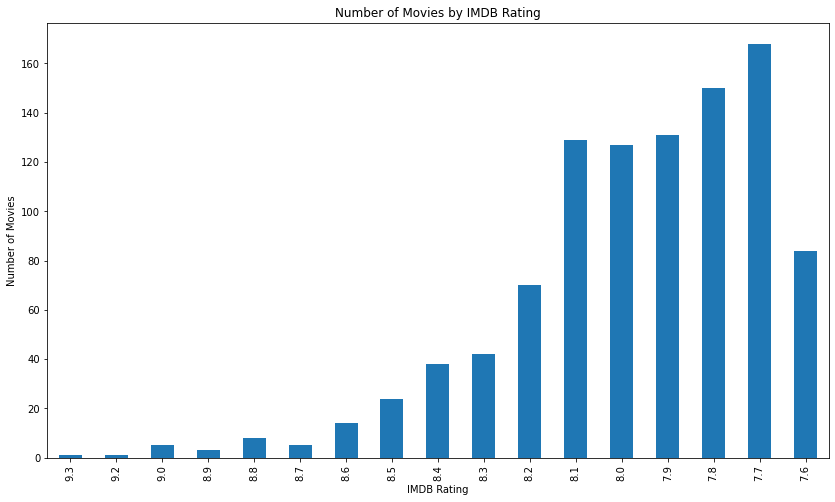

In [20]:
ax = movies_df['IMDB Rating'].value_counts().sort_index(ascending=False).plot(kind='bar',
                                   figsize=(14,8),
                                   title="Number of Movies by IMDB Rating")
ax.set_xlabel("IMDB Rating")
ax.set_ylabel("Number of Movies")
ax.plot();

PLotting chart to see average metascore per year.

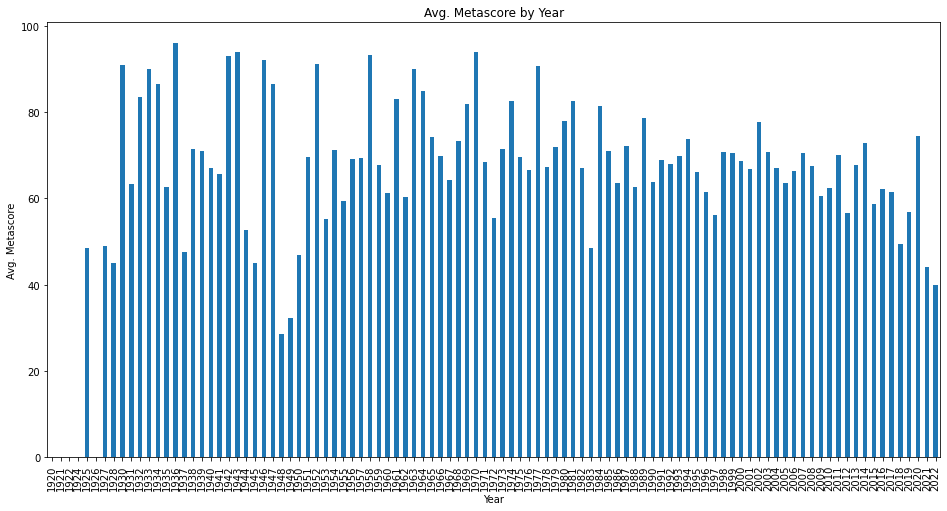

In [21]:
movies_df.groupby('Movie Year')['Metascore'].mean().plot(kind='bar', figsize=(16,8), title="Avg. Metascore by Year", xlabel="Year", ylabel="Avg. Metascore")
plt.xticks(rotation=90)
plt.plot();